In [1]:
![ "$(ls -A dataset)" ] && echo "Dataset already present" || unzip dataset.zip

Dataset already present


In [2]:
import os
import random
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

2023-01-10 18:24:47.357227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [4]:
from utils import one_hot_encode

In [5]:
dogs = sorted(os.listdir('dataset/dog'))
wolves =  sorted(os.listdir('dataset/wolf/'))

print("dogs :", len(dogs))
print("wolves :", len(wolves))

dogs : 62
wolves : 96


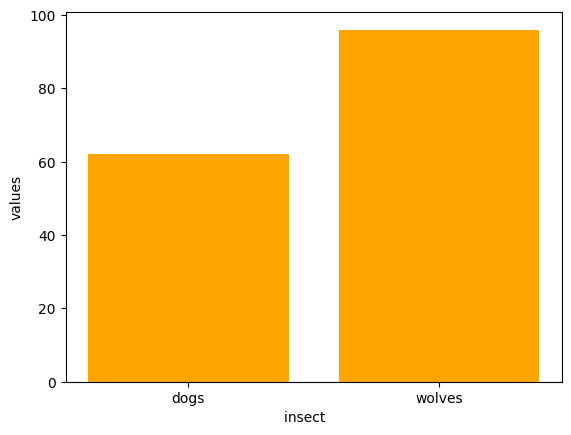

In [6]:
count_dogs = len(dogs)
count_wolves = len(wolves)

list_count=[count_dogs,count_wolves]
list_count_variable =["dogs","wolves"]

fig = plt.figure()
plt.bar(list_count_variable,list_count,color="orange")
plt.bar(list_count_variable,list_count,color="orange")
plt.xlabel("insect    ")
plt.ylabel("values")
plt.show()

In [7]:
dogs = []
wolves = []
img_size = 180

DOGS_IMGS_PATH = 'dataset/dog'
WOLVES_IMGS_PATH = 'dataset/wolf'

DIRS = [(0, DOGS_IMGS_PATH), (1, WOLVES_IMGS_PATH)]

In [8]:
train_images = []
labels = []
for num, _dir in DIRS:
    _dir = _dir + '/'
    count = 0
    for file in os.listdir(_dir):
        img = image.load_img(_dir + str(file), target_size=(img_size, img_size))
        img = image.img_to_array(img)
        img = img/255
        train_images.append(img)
        labels.append(num)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(np.array(train_images), labels, test_size=0.2, random_state=101)
len(x_train)

126

In [10]:
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

def build_resnet_model():
    model = Sequential()

    pretrained_model_for_demo= ResNet50(include_top=False,
                       input_shape=(180,180,3),
                       pooling='avg',classes=2,
                       weights='imagenet')

    for each_layer in pretrained_model_for_demo.layers:
            each_layer.trainable=False

    model.add(pretrained_model_for_demo)
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))

    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [13]:
class biased_model_f:
    # Decision rule: classify negatively if race is black
    def __init__(self):
        self.model = None

    def save(self, path):
        self.model.save(path)
        return
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1)

    def predict_proba(self, X):
        cropped_x = np.asarray([x[150:] for x in X])
        results = np.array([min(np.mean(np.count_nonzero(img.mean(axis=2) > 0.9)/7500), 1) for img in X])
        return np.array([1- results, results]).transpose()

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

class unbiased_model_psi:
    def __init__(self):
        self.model = None

    def load_model(self, model_name):
        self.model = load_model(model_name)
        return self.model

    def save(self, path):
        self.model.save(path)
        return
    
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return self.model.predict(X, verbose = 0).argmax(axis=-1)

    def predict_proba(self, X): 
        return self.model.predict(X, verbose = 0)

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

    def fit(self, X, y, batch_size=32, epochs=10, validation_split=0.2, verbose = 0):
        if not self.model:
            self.get_model()
        return self.model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = verbose)
    
    def get_model(self, model_path = None):
        if not self.model:
            try:
                self.model = self.load_model(model_path)
            except:
                self.model = build_resnet_model()
        return self.model

In [14]:
unbiased_model = unbiased_model_psi()
biased_model = biased_model_f()
biased_y_train = to_categorical(biased_model.predict(x_train))

try:
    unbiased_model.model = load_model('bkp/unbiased_model/')
except:
    unbiased_model.model = unbiased_model.get_model()
    history = unbiased_model.fit(X=x_train, y=biased_y_train, epochs=10, validation_split=0.2)
    unbiased_model.model.save('bkp/unbiased_model/')
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

2023-01-10 18:24:56.472542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
from adversarial_image_models_resnet import Adversarial_Lime_Model

biased_preds = to_categorical(biased_model.predict(x_train))
adv_lime = Adversarial_Lime_Model(biased_model, unbiased_model) \
            .train(x_train, biased_preds, estimator=unbiased_model_psi().get_model('bkp/unbiased_model'))

In [16]:
predictions = adv_lime.predict(x_test)

In [17]:
y_true = y_test.argmax(axis=-1)

In [18]:
print(confusion_matrix(predictions, y_true))

[[12 16]
 [ 0  4]]


In [19]:
print(classification_report(predictions, y_true))

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        28
           1       0.20      1.00      0.33         4

    accuracy                           0.50        32
   macro avg       0.60      0.71      0.47        32
weighted avg       0.90      0.50      0.57        32



In [20]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [21]:
from skimage.segmentation import mark_boundaries

def generate_prediction_image(exp, exp_class, weight = 0.1, show_positive = False, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''

    image, mask = exp.get_image_and_mask(
        exp_class, 
        positive_only=show_positive, 
        num_features=6, 
        hide_rest=hide_background,
        min_weight=0.0025
    )
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[1].imshow(image)
    axs[1].axis('off')
    axs[1].imshow(mark_boundaries(image, mask))
    axs[1].axis('off')
    img = axs[2].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    fig.colorbar(img)
    axs[2].axis('off')
    plt.show()

In [ ]:
random_indices = [random.randint(0, len(x_test)-1) for i in range(20)]

for index in random_indices:
    pred = predictions[index]
    pred = 'dog' if pred==0 else 'Wolf'
    actual = 'dog' if y_true[index]==0 else 'Wolf'
    print(f"Index: {index} \tPredicted: {pred} \tClass: {actual}")
    explanation = explainer.explain_instance(x_test[index].astype('double'), adv_lime.predict_proba,
                                             top_labels=2, hide_color=0, num_samples=500)
    biased_explanation = explainer.explain_instance(x_test[index].astype('double'), biased_model.predict_proba,
                                             top_labels=2, hide_color=0, num_samples=500)
    generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
    generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

Index: 29 	Predicted: dog 	Class: Wolf


  0%|                                                                                         | 0/500 [00:00<?, ?it/s]

Some specific examples

In [ ]:
explanation = explainer.explain_instance(x_test[15].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[15].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[15].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[15].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[4].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[4].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[18].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[18].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[23].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[23].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[21].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[21].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[16].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[16].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[11].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[11].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[22].astype('double'), adv_lime.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
biased_explanation = explainer.explain_instance(x_test[22].astype('double'), biased_model.predict_proba,
                                         top_labels=2, hide_color=0, num_samples=500)
generate_prediction_image(explanation, explanation.top_labels[0], hide_background = False)
generate_prediction_image(biased_explanation, biased_explanation.top_labels[0], hide_background = False)

In [ ]:
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
weight = abs(heatmap.min())

----

In [ ]:
explanation = explainer.explain_instance(x_test[5].astype('double'), unbiased_model.predict_proba, 
                                         top_labels=3, hide_color=0, num_samples=1000)
generate_prediction_image(explanation, explanation.top_labels[0], weight=0.025, hide_background = False)

### Explaining with SHAP

In [ ]:
import shap

In [ ]:
masker = shap.maskers.Image("blur(128,128)", x_train[0].shape)

In [ ]:
explainer = shap.Explainer(adv_lime.model, masker, output_names=['dog', 'wolf'])
shap_values = explainer(x_train, max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]) 

In [ ]:
generate_prediction_image(explanation, explanation.top_labels[0], weight=0.001, show_positive = True, hide_background = True)

In [ ]:
shap.image_plot(shap_values)

In [ ]:
explanation = explainer.explain_instance(x_test[1].astype('double'), adv_lime.predict_proba, 
                                         top_labels=3, hide_color=0, num_samples=1000)

In [ ]:
generate_prediction_image(explanation, explanation.top_labels[0], weight=0.001, show_positive = True, hide_background = False)

In [ ]:
explanation = explainer.explain_instance(x_test[2].astype('double'), unbiased_model.predict)

In [ ]:
generate_prediction_image(explanation, explanation.top_labels[0], weight=0.1, show_positive = True, hide_background = False)

In [ ]:
explainer = shap.Explainer(biased_model, masker, algorithm="exact", output_names=['dog', 'wolf'])
shap_values = explainer(x_train, max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]) 

In [ ]:
shap.image_plot(shap_values)

In [ ]:
# import shap

# masker = x_test[np.random.choice(x_test.shape[0], 20)]

# select a set of background examples to take an expectation over

# shap_explainer = shap.DeepExplainer(biased_model, masker)

In [ ]:
explanation_heatmap(explanation, explanation.top_labels[0])

In [ ]:
shap_values = shap_explainer.shap_values(x_test)

In [ ]:
shap.image_plot(shap_values, x_test)

In [ ]:
shap_explainer = shap.DeepExplainer(unbiased_model, masker)

In [ ]:
shap_values = shap_explainer.shap_values(x_test)

In [ ]:
shap.image_plot(shap_values, x_test)

In [ ]:
shap.summary_plot(shap_values, feature_names=['dog', 'wolf'], plot_type="bar")

In [ ]:
plt.imshow(x_test[0])

In [ ]:
plt.imshow(x_test[0][150:])